In [4]:
pip install ta


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
pip install dash

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
import yfinance as yf #getting data
import pandas as pd #data handling
import numpy as np #calc
import ta #tech indi
import matplotlib.pyplot as plt #visualization
from dash import Dash,Input, Output, dcc, html,callback, dash_table


In [9]:
df=yf.download('AAPL',start='2019-01-01')

[*********************100%%**********************]  1 of 1 completed


In [10]:
df['ma_20']=df.Close.rolling(20).mean()
df['vol']=df.Close.rolling(20).std()
df['upper_bb']=df.ma_20+(2*df.vol)
df['lower_bb']=df.ma_20-(2*df.vol)


In [11]:
df.reset_index(inplace=True)


In [12]:
df.columns


Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'ma_20',
       'vol', 'upper_bb', 'lower_bb'],
      dtype='object')

In [13]:
df.tail(10)

,Date,Open,High,Low,Close,Adj Close,Volume,ma_20,vol,upper_bb,lower_bb
1428,2024-09-05,221.630005,225.479996,221.520004,222.380005,222.380005,36615400,223.875000,4.368126,232.611253,215.138747
1429,2024-09-06,223.949997,225.240005,219.770004,220.820007,220.820007,48423000,224.250500,3.680844,231.612189,216.888812
1430,2024-09-09,220.820007,221.270004,216.710007,220.910004,220.910004,67180000,224.484000,3.271280,231.026560,217.941441
1431,2024-09-10,218.919998,221.479996,216.729996,220.110001,220.110001,51591000,224.613000,3.024158,230.661316,218.564685
1432,2024-09-11,221.460007,223.089996,217.889999,222.660004,222.660004,44587100,224.682500,2.958547,230.599595,218.765406
1433,2024-09-12,222.500000,223.550003,219.820007,222.770004,222.770004,37498200,224.735001,2.912163,230.559326,218.910675
1434,2024-09-13,223.580002,224.039993,221.910004,222.500000,222.500000,36766600,224.624001,2.954762,230.533524,218.714477
1435,2024-09-16,216.539993,217.220001,213.919998,216.320007,216.320007,59357400,224.137501,3.464640,231.066781,217.208220
1436,2024-09-17,215.750000,216.899994,214.500000,216.789993,216.789993,45519300,223.682500,3.803357,231.289215,216.075786
1437,2024-09-18,217.550003,222.710007,217.539993,220.690002,220.690002,59788400,223.391501,3.798280,230.988061,215.794940


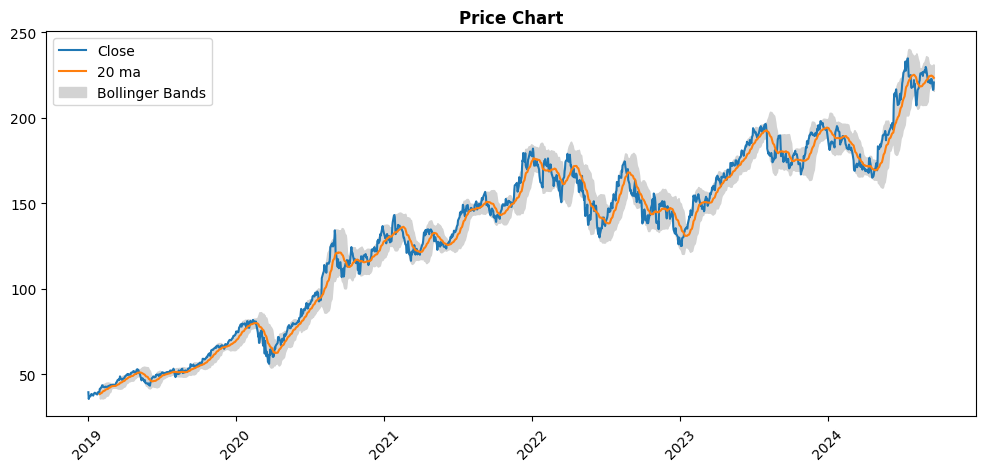

In [14]:
plt.figure(figsize=(12,5))
plt.xticks(rotation=45)

x_axis = df['Date']

plt.plot(x_axis, df['Close'], label = 'Close')
plt.plot(df['Date'], df['ma_20'], label = '20 ma')
plt.fill_between(x_axis, df['upper_bb'], df['lower_bb'], label = 'Bollinger Bands', color='lightgrey')

plt.title('Price Chart', fontweight="bold")
plt.legend()
plt.show()

Calculating
Relative Strength Index (RSI) measures the magnitude of recent price changes and evaluates if a stock has been overbought or oversold.


In [15]:
def gain(value):
    if value < 0:
        return 0
    else:
        return value

In [16]:
def loss(value):
    if value > 0:
        return 0
    else:
        return abs(value)

In [17]:
period = 6

#Calculate price delta
df['delta'] = df['Close'].diff()

#Classify delta into gain & loss
df['gain'] = df['delta'].apply(lambda x:gain(x))
df['loss'] = df['delta'].apply(lambda x:loss(x))

#Calculate ema
df['ema_gain'] = df['gain'].ewm(period).mean()
df['ema_loss'] = df['loss'].ewm(period).mean()

#Calculate RSI
df['rs'] = df['ema_gain']/df['ema_loss']
df['rsi'] = df['rs'].apply(lambda x: 100 - (100/(x+1)))

or use direct technical indicator library to find rsi

In [18]:
df['rsi_direct']=ta.momentum.rsi(df.Close,window=6)

(0.0, 100.0)

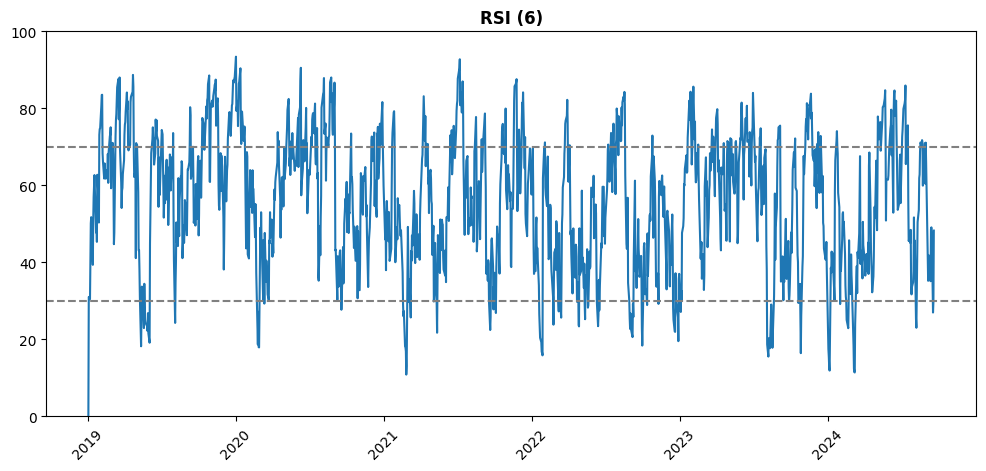

In [19]:
#plot for validation
plt.figure(figsize=(12,5))
plt.xticks(rotation=45)

x_axis = df['Date']

plt.plot(x_axis, df['rsi'])
plt.axhline(30, c= (.5,.5,.5), ls='--')
plt.axhline(70, c= (.5,.5,.5), ls='--')

plt.title('RSI (6)', fontweight="bold")
plt.ylim([0, 100])

##Implementing buy/sell




1. Buy when 10-period RSI below 30 (buy next day) & Price below lower bollinger band
2. Sell when 10-period RSI above 70 (sell next day) & Price above upper bollinger band


In [20]:
#buy signal
df['signal'] = np.where(
    (df['rsi'] < 30) &
    (df['Close'] < df['lower_bb']), 1, np.nan)

#sell signal
df['signal'] = np.where(
    (df['rsi'] > 70) &
    (df['Close'] > df['upper_bb']), -1, df['signal'])

#buy/sell next trading day
df['signal'] = df['signal'].shift()
df['signal'] = df['signal'].fillna(0)

In [21]:
#buy signal
df['signal'] = np.where(
    (df['rsi'] < 30) &
    (df['Close'] < df['lower_bb']), 1, np.nan)

#sell signal
df['signal'] = np.where(
    (df['rsi'] > 70) &
    (df['Close'] > df['upper_bb']), -1, df['signal'])

#buy/sell next trading day
df['signal'] = df['signal'].shift()
df['signal'] = df['signal'].fillna(0)

In [22]:
print(df)

           Date        Open        High         Low       Close   Adj Close  \
0    2019-01-02   38.722500   39.712502   38.557499   39.480000   37.750080   
1    2019-01-03   35.994999   36.430000   35.500000   35.547501   33.989902   
2    2019-01-04   36.132500   37.137501   35.950001   37.064999   35.440907   
3    2019-01-07   37.174999   37.207500   36.474998   36.982498   35.362015   
4    2019-01-08   37.389999   37.955002   37.130001   37.687500   36.036125   
...         ...         ...         ...         ...         ...         ...   
1433 2024-09-12  222.500000  223.550003  219.820007  222.770004  222.770004   
1434 2024-09-13  223.580002  224.039993  221.910004  222.500000  222.500000   
1435 2024-09-16  216.539993  217.220001  213.919998  216.320007  216.320007   
1436 2024-09-17  215.750000  216.899994  214.500000  216.789993  216.789993   
1437 2024-09-18  217.550003  222.710007  217.539993  220.690002  220.690002   

         Volume       ma_20       vol    upper_bb  

In [23]:
import pandas as pd
import numpy as np


def backtest_dataframe(df):
    position = 0
    net_profit = 0
    percentage_change = []
    df['buy_date'] = ''
    df['sell_date'] = ''

    for i in df.index:
        close = df["Close"][i]
        date = df['Date'][i]

        # Buy action
        if df["signal"][i] == 1:
            if(position == 0):
                buy_price = close
                position = 1
                df.at[i, 'buy_date'] = date
                print(f"Buying at {str(buy_price)} on {str(date)}")

        # Sell action
        elif (df["signal"][i] == -1):
            if(position == 1):
                sell_price = close
                bought = 0
                position = 0
                df.at[i, 'sell_date'] = date
                print(f"Selling at {str(sell_price)} on {str(date)}")

                # Get percentage change of trade
                pc = (sell_price/buy_price-1)*100
                percentage_change.append(pc)
                net_profit += (sell_price - buy_price)

    # Calculate trade statistics
    gains = 0
    ng = 0
    losses = 0
    nl = 0
    totalR = 1

    for i in percentage_change:
        if(i > 0):
            gains += i
            ng += 1
        else:
            losses += i
            nl += 1
        totalR = totalR * ((i/100)+1)

    totalR = round((totalR-1)*100, 2)

    if(ng > 0):
        avgGain = round(gains/ng, 2)
        maxR = round(max(percentage_change), 2)
    else:
        avgGain = 0
        maxR = "undefined"

    if(nl > 0):
        avgLoss = round(losses/nl, 2)
        maxL = round(min(percentage_change), 2)
    else:
        avgLoss = 0
        maxL = "undefined"

    if(ng > 0 or nl > 0):
        win_rate = round((ng/(ng+nl))*100, 2)
    else:
        win_rate = 0

    Metric=['Number of Trades','Number of Gains','Number of Losses','Total Returns %','Win Rate %','Average Gain %','Average Loss %','Max Return %','Max Loss %']
    Value=[ng+nl,ng,nl,totalR,win_rate,avgGain,avgLoss,maxR,maxL]
    results=pd.DataFrame({'Metric': Metric,
        'Value': Value})
    print()
    print('Evaluation Metrics:')
    print('-----------------------------------')
    print(f"Number of Trades: {ng+nl}")
    print(f"Number of Gains: {ng}")
    print(f"Number of Losses: {nl}")
    print(f"Total Returns: {totalR}%")
    print(f"Win Rate: {win_rate}%")
    print(f"Average Gain: {avgGain}%")
    print(f"Average Loss: {avgLoss}%")
    print(f"Max Return: {maxR}%")
    print(f"Max Loss: {maxL}%")
    print()
    return results

In [24]:
print(df)

           Date        Open        High         Low       Close   Adj Close  \
0    2019-01-02   38.722500   39.712502   38.557499   39.480000   37.750080   
1    2019-01-03   35.994999   36.430000   35.500000   35.547501   33.989902   
2    2019-01-04   36.132500   37.137501   35.950001   37.064999   35.440907   
3    2019-01-07   37.174999   37.207500   36.474998   36.982498   35.362015   
4    2019-01-08   37.389999   37.955002   37.130001   37.687500   36.036125   
...         ...         ...         ...         ...         ...         ...   
1433 2024-09-12  222.500000  223.550003  219.820007  222.770004  222.770004   
1434 2024-09-13  223.580002  224.039993  221.910004  222.500000  222.500000   
1435 2024-09-16  216.539993  217.220001  213.919998  216.320007  216.320007   
1436 2024-09-17  215.750000  216.899994  214.500000  216.789993  216.789993   
1437 2024-09-18  217.550003  222.710007  217.539993  220.690002  220.690002   

         Volume       ma_20       vol    upper_bb  

In [25]:
a=backtest_dataframe(df)
print(a)

Buying at 47.165000915527344 on 2019-05-14 00:00:00
Selling at 52.10749816894531 on 2019-08-01 00:00:00
Buying at 49.25 on 2019-08-06 00:00:00
Selling at 55.772499084472656 on 2019-09-12 00:00:00
Buying at 72.0199966430664 on 2020-02-25 00:00:00
Selling at 71.10749816894531 on 2020-04-15 00:00:00
Buying at 125.86000061035156 on 2021-02-23 00:00:00
Selling at 130.36000061035156 on 2021-04-08 00:00:00
Buying at 128.10000610351562 on 2021-05-05 00:00:00
Selling at 129.63999938964844 on 2021-06-15 00:00:00
Buying at 143.42999267578125 on 2021-09-21 00:00:00
Selling at 149.25999450683594 on 2021-10-20 00:00:00
Buying at 164.50999450683594 on 2022-01-20 00:00:00
Selling at 174.72000122070312 on 2022-03-25 00:00:00
Buying at 156.57000732421875 on 2022-04-27 00:00:00
Selling at 154.08999633789062 on 2022-07-22 00:00:00
Buying at 157.22000122070312 on 2022-08-31 00:00:00
Selling at 149.35000610351562 on 2022-10-26 00:00:00
Buying at 134.50999450683594 on 2022-12-16 00:00:00
Selling at 142.52999

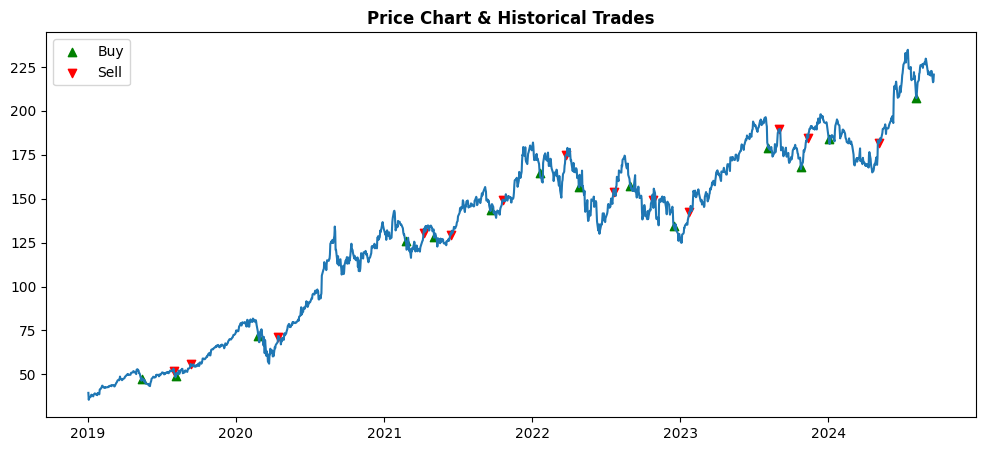

In [26]:
plt.figure(figsize=(12,5))
# plt.xticks(rotation=45)

plt.plot(df['Date'], df['Close'])
plt.scatter(df[(df['signal'] == 1)]['buy_date'], df[(df['signal'] == 1)]['Close'], label = 'Buy', marker='^', c='g')
plt.scatter(df[(df['signal'] == -1)]['sell_date'], df[(df['signal'] == -1)]['Close'], label = 'Sell', marker='v', c='r')

plt.title('Price Chart & Historical Trades', fontweight="bold")
plt.legend()
plt.show()

In [27]:
#implimenting stop losses

In [28]:
conditions=[(df.rsi<30)&(df.Close<df.lower_bb),(df.rsi>70)&(df.Close>df.upper_bb)]
choices=['Buy','Sell']
df['signal']=np.select(conditions,choices)
df.dropna(inplace=True)
df.signal=df.signal.shift()

In [29]:
#shifting signal logic/buyprice

In [30]:
df['shifted_Close']=df.Close.shift()

In [31]:
position=False
buydates,selldates=[],[]
buyprices,sellprices=[],[]

for index,row in df.iterrows():
  if not position and row['signal']=='Buy':
    buydates.append(index)
    buyprices.append(row.Open)
    position=True

  if position:
    if row['signal']=='Sell' or row.shifted_Close<0.95*buyprices[-1]:

      selldates.append(index)
      sellprices.append(row.Open)
      position=False

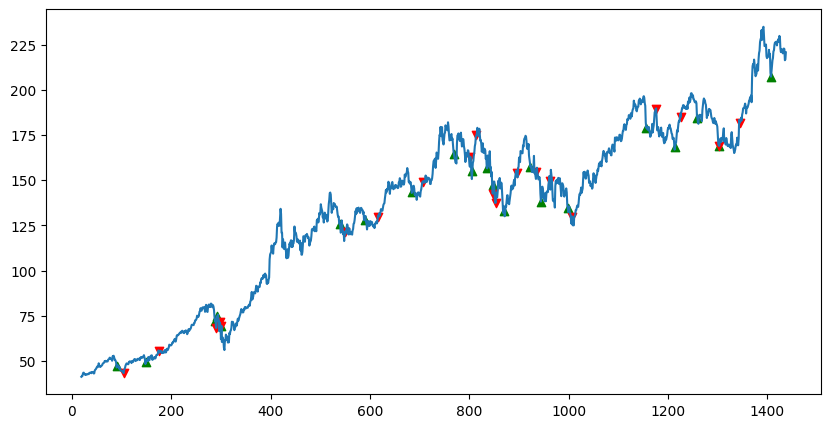

In [32]:

plt.figure(figsize=(10,5))
plt.plot(df.Close)
plt.scatter(df.loc[buydates].index,df.loc[buydates].Close,marker='^',c='g')
plt.scatter(df.loc[selldates].index,df.loc[selldates].Close,marker='v',c='r')


In [33]:
MR= round((pd.Series([(sell-buy)/buy for sell,buy in zip(sellprices,buyprices)])+1).prod(),2)
ML=round((pd.Series([(sell-buy)/buy for sell,buy in zip(sellprices,buyprices)])+1).prod()-1,2) #cumulatative return/losses

print(f"Max Return: {MR*100}%")
print(f"Max Loss: {ML*100}%")

Max Return: 112.00000000000001%
Max Loss: 12.0%


In [37]:
from dash import Dash, html, dcc, callback, Output, Input
import dash_table
import yfinance as yf

# Create a Dash app
app = Dash(__name__)

app.layout = html.Div([
    html.H1('Mean Reversion - Stock Screener'),

    html.Div([
        dcc.Dropdown(
            id="stock_name",
            options=[
                {"label": "Apple (AAPL)", "value": "AAPL"},
                {"label": "Square (SQ)", "value": "SQ"}
            ],
            placeholder="Select a Stock"
        ),
        html.Div(id="table")  # Directly set the id here for clarity
    ])
])

@callback(
    Output(component_id='table', component_property='children'),
    Input(component_id='stock_name', component_property='value')
)
def update_output_div(input_value):
    if input_value is None:
        return html.Div("Select a stock to see the data.")
    
    # Fetch stock data
    df = yf.download(input_value, start='2019-01-01')
    if df.empty:
        return html.Div("No data found for the selected stock.")
    
    # Create a DataTable to display stock data
    data_table = dash_table.DataTable(
        data=df.reset_index().to_dict('records'),  # Reset index to include date
        columns=[{"name": i, "id": i} for i in df.reset_index().columns],
        style_table={'overflowX': 'auto'},
        style_header={
            'backgroundColor': 'rgb(240,248,255)',
            'fontWeight': 'bold'
        },
        page_size=10  # Set page size for better usability
    )
    
    return data_table

# Run the app with specified host and port
if __name__ == '__main__':
    app.run_server(debug=True, host='127.0.0.1', port=8053)


[*********************100%%**********************]  1 of 1 completed
